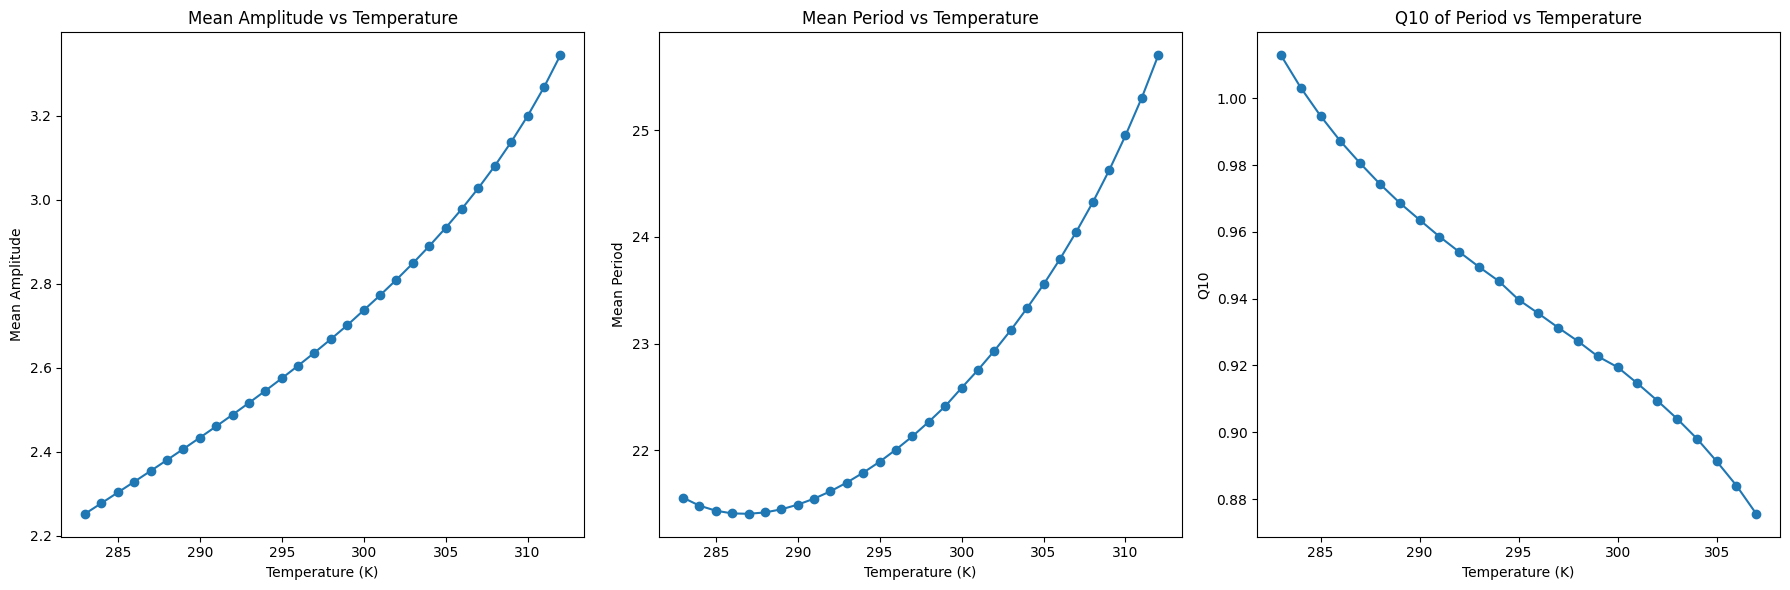

In [71]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def kaiABC_Rust(c, t, Temp):
    T = c[0]
    ST = c[1]
    S = c[2]

    KaiA = 1.3
    x = 298.15
    
    khalf = 383.83 * np.exp(-(16.8330449e3) / (8.3144598 * Temp))
    
    kUT0 = 0.0
    kUTA = 383.83 * np.exp(-(16.56527851e3) / (8.3144598 * Temp))
   
    kDT0 = 0.0
    kDTA = 383.83 * np.exp(-(19.08885839e3) / (8.3144598 * x))
   
    kTU0 = 383.83 * np.exp(-(18.60866545e3) / (8.3144598 * x))
    kTUA = 383.83 * np.exp(-(21.0046209e3) / (8.3144598 * Temp))
    
    kTD0 = 0.0
    kTDA = 383.83 * np.exp(-(18.5744178e3) / (8.3144598 * Temp))
   
    kSD0 = 0.0
    kSDA = 383.83 * np.exp(-(16.43132499e3) / (8.3144598 * Temp))
    
    kDS0 = 383.83 * np.exp(-(17.64373845e3) / (8.3144598 * x))
    kDSA = 383.83 * (-np.exp(-(17.56984493e3) / (8.3144598 * Temp)))
    
    kUS0 = 0.0
    kUSA = 383.83 * np.exp(-(22.00905957e3) / (8.3144598 * Temp))
    
    kSU0 = 383.83 * np.exp(-(20.21073081e3) / (8.3144598 * x))
    kSUA = 383.83 * (-np.exp(-(19.73888331e3) / (8.3144598 * Temp)))
    
    KaiC = 3.4

    U = max(0, KaiC - T - ST - S)
    A = max(0, 1.3 - 2. * S)

    kUT = kUT0 + ((kUTA * A) / (khalf + A))
    kDT = kDT0 + ((kDTA * A) / (khalf + A))
    kTU = kTU0 + ((kTUA * A) / (khalf + A))
    kTD = kTD0 + ((kTDA * A) / (khalf + A))
    kSD = kSD0 + ((kSDA * A) / (khalf + A))
    kDS = kDS0 + ((kDSA * A) / (khalf + A))
    kUS = kUS0 + ((kUSA * A) / (khalf + A))
    kSU = kSU0 + ((kSUA * A) / (khalf + A))
    
    dTdt = (kUT * U + kDT * ST - kTU * T - kTD * T)
    dSTdt = (kTD * T + kSD * ST - kDT * ST - kDS * ST)
    dSdt = (kUS * U + kDS * ST - kSU * S - kSD * S)
    
    return [dTdt, dSTdt, dSdt]

def analyze_oscillator_behavior(Temp):
    t0 = 0
    tf = 250
    tspan = np.arange(t0, tf, 0.02)
    css = [0.68, 1.36, 0.34]

    sol = odeint(kaiABC_Rust, css, tspan, args=(Temp,))
    T_val = sol[:, 0]
    ST_val = sol[:, 1]
    S_val = sol[:, 2]

    total_protein = T_val + ST_val + S_val

    peaks, _ = find_peaks(total_protein)
    amplitudes = total_protein[peaks]

    if len(peaks) > 1:
        periods = np.diff(tspan[peaks])
        mean_period = np.mean(periods)
    else:
        mean_period = np.nan

    mean_amplitude = np.mean(amplitudes)

    return mean_amplitude, mean_period

# Evaluate over a range of temperatures
temperatures = np.arange(283, 313, 1)
mean_amplitudes = []
mean_periods = []

for Temp in temperatures:
    mean_amplitude, mean_period = analyze_oscillator_behavior(Temp)
    mean_amplitudes.append(mean_amplitude)
    mean_periods.append(mean_period)

# Calculate Q10 for period
Q10_values = []

for i in range(len(temperatures) - 5):
    T1 = temperatures[i]
    T2 = temperatures[i + 5]
    rate1 = 1 / mean_periods[i]
    rate2 = 1 / mean_periods[i + 5]
    
    Q10 = (rate2 / rate1) ** (10 / (T2 - T1))
    Q10_values.append(Q10)

# Plot mean amplitude and mean period against temperature
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(temperatures, mean_amplitudes, marker='o')
plt.xlabel('Temperature (K)')
plt.ylabel('Mean Amplitude')
plt.title('Mean Amplitude vs Temperature')

plt.subplot(1, 3, 2)
plt.plot(temperatures, mean_periods, marker='o')
plt.xlabel('Temperature (K)')
plt.ylabel('Mean Period')
plt.title('Mean Period vs Temperature')

plt.subplot(1, 3, 3)
plt.plot(temperatures[:-5], Q10_values, marker='o')
plt.xlabel('Temperature (K)')
plt.ylabel('Q10')
plt.title('Q10 of Period vs Temperature')

plt.tight_layout()
plt.show()
